# Impor pustaka yang diperlukan

In [128]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler


# Memuat Data

In [129]:
# Instalasi API Kaggle untuk mengunduh dataset
!pip install kaggle

# Unggah Kunci API Kaggle untuk autentikasi
from google.colab import files
files.upload()  # Unggah file kaggle.json Anda

# Setel Kunci API Kaggle sebagai variabel lingkungan
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content'

# Unduh dataset dari Kaggle (sesuaikan ID dataset jika diperlukan)
!kaggle datasets download -d rishidamarla/costs-for-cancer-treatment

# Ekstrak file dataset
!unzip costs-for-cancer-treatment.zip

Saving kaggle.json to kaggle (3).json
Dataset URL: https://www.kaggle.com/datasets/rishidamarla/costs-for-cancer-treatment
License(s): CC0-1.0
costs-for-cancer-treatment.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  costs-for-cancer-treatment.zip
replace DowloadableDataFull_2011.01.12.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: DowloadableDataFull_2011.01.12.csv  


# Memuat dataset dan eksplorasi awal

In [130]:
# Muat dataset (pastikan path atau URL sudah benar)
url = 'DowloadableDataFull_2011.01.12.csv'  # Gantilah dengan path yang sesuai jika diperlukan
data = pd.read_csv(url, skiprows=2)  # Lewati dua baris pertama
data.columns = data.iloc[0]  # Set baris keempat sebagai header
data = data[1:]  # Hapus baris header sebelumnya

# Ubah kolom menjadi numerik jika perlu
data['Year'] = pd.to_numeric(data['Year'], errors='coerce')
data['Total Costs'] = pd.to_numeric(data['Total Costs'], errors='coerce')

# Tampilkan 5 baris pertama untuk inspeksi awal
print(data.head())

0 Cancer Site  Year         Sex       Age  \
1    AllSites  2010  Both sexes  All ages   
2    AllSites  2010  Both sexes  All ages   
3    AllSites  2010  Both sexes  All ages   
4    AllSites  2010  Both sexes  All ages   
5    AllSites  2010  Both sexes  All ages   

0                 Incidence and Survival Assumptions  \
1               Incidence, Survival at constant rate   
2  Incidence follows recent trend, Survival constant   
3  Survival follows recent trend, Incidence constant   
4           Incidence, Survival follow recent trends   
5           Incidence, Survival follow recent trends   

0 Annual Cost Increase (applied to initial and last phases)  Total Costs  \
1                                                 0%            124565.6   
2                                                 0%            122420.8   
3                                                 0%            125397.7   
4                                                 0%            123236.3   
5           

## Deskripsi Variabel

In [131]:
# Tampilkan nama kolom dan tipe data
print("Tipe Data dan Nilai Null:\n", data.info())
print("Statistik Ringkas:\n", data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1254 entries, 1 to 1254
Data columns (total 10 columns):
 #   Column                                                     Non-Null Count  Dtype  
---  ------                                                     --------------  -----  
 0   Cancer Site                                                1254 non-null   object 
 1   Year                                                       1254 non-null   int64  
 2   Sex                                                        1254 non-null   object 
 3   Age                                                        1254 non-null   object 
 4   Incidence and Survival Assumptions                         1254 non-null   object 
 5   Annual Cost Increase (applied to initial and last phases)  1254 non-null   object 
 6   Total Costs                                                1254 non-null   float64
 7   Initial Year After Diagnosis Cost                          1254 non-null   object 
 8   Continui

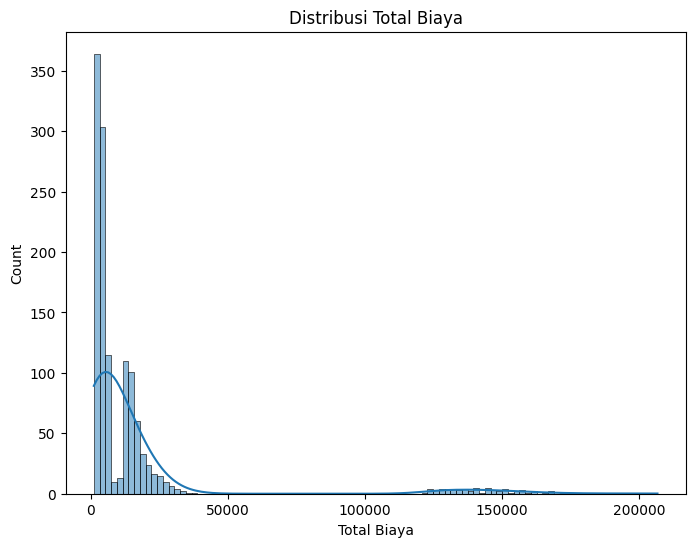

In [132]:
# Plot histogram untuk Total Costs
plt.figure(figsize=(8, 6))
sns.histplot(data['Total Costs'].dropna(), kde=True)
plt.title('Distribusi Total Biaya')
plt.xlabel('Total Biaya')
plt.show()

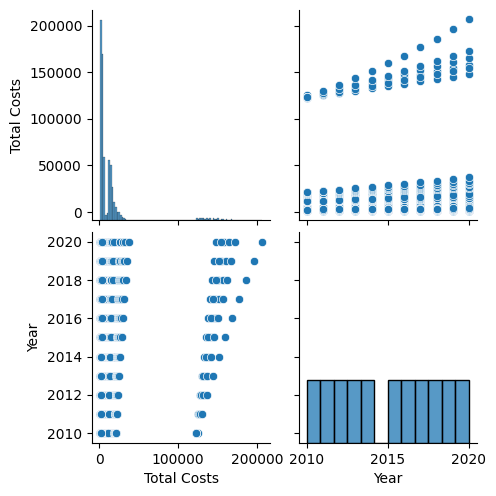

In [133]:
# Pairplot untuk variabel kontinu
sns.pairplot(data[['Total Costs', 'Year']].dropna())
plt.show()


# Persiapan Data

In [135]:
# Menghapus simbol '%' pada kolom 'Annual Cost Increase' dan mengonversinya menjadi float
data['Annual Cost Increase (applied to initial and last phases)'] = (
    data['Annual Cost Increase (applied to initial and last phases)']
    .replace('%', '', regex=True)
    .astype(float) / 100
)

In [136]:
# One-Hot Encoding untuk kolom kategorikal
data_encoded = pd.get_dummies(data, columns=['Cancer Site', 'Sex', 'Age', 'Incidence and Survival Assumptions'], drop_first=True)


In [137]:
# Tampilkan 5 baris pertama untuk inspeksi awal
print(data.head())

0 Cancer Site  Year         Sex       Age  \
1    AllSites  2010  Both sexes  All ages   
2    AllSites  2010  Both sexes  All ages   
3    AllSites  2010  Both sexes  All ages   
4    AllSites  2010  Both sexes  All ages   
5    AllSites  2010  Both sexes  All ages   

0                 Incidence and Survival Assumptions  \
1               Incidence, Survival at constant rate   
2  Incidence follows recent trend, Survival constant   
3  Survival follows recent trend, Incidence constant   
4           Incidence, Survival follow recent trends   
5           Incidence, Survival follow recent trends   

0  Annual Cost Increase (applied to initial and last phases)  Total Costs  \
1                                             0.0000             124565.6   
2                                             0.0000             122420.8   
3                                             0.0000             125397.7   
4                                             0.0000             123236.3   
5      

In [138]:
# Tentukan fitur dan target
fitur = data_encoded.drop(columns=['Total Costs'])  # Gantilah dengan nama kolom target jika berbeda
target = data_encoded['Total Costs']

In [139]:
# Pisahkan data menjadi set pelatihan dan pengujian
X_train, X_test, y_train, y_test = train_test_split(fitur, target, test_size=0.2, random_state=42)

In [140]:
# Cek ukuran sampel
print("Jumlah sampel pelatihan:", len(X_train))
print("Jumlah sampel pengujian:", len(X_test))

Jumlah sampel pelatihan: 1003
Jumlah sampel pengujian: 251


In [142]:
# Standarisasi fitur
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Konfirmasi standarisasi
print("Rata-rata X_train:", X_train.mean(axis=0))
print("Deviasi standar X_train:", X_train.std(axis=0))

Rata-rata X_train: [ 5.13602675e-17  2.83366993e-17  0.00000000e+00  2.21380464e-18
 -1.15117841e-17  2.47946119e-17 -1.41683497e-17 -2.39090901e-17
 -2.47946119e-17 -2.03670026e-17  2.12525245e-17  7.08417483e-18
  3.18787867e-17 -2.47946119e-17  0.00000000e+00  2.83366993e-17
  2.92222212e-17  1.31057234e-16 -1.31057234e-16  8.85521854e-18
 -2.74511775e-17  7.79259232e-17  1.77104371e-17  7.08417483e-18
 -2.74511775e-17 -3.18787867e-17  3.09932649e-17  2.30235682e-17]
Deviasi standar X_train: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]


# Pengembangan Model

In [143]:
# DataFrame untuk perbandingan model
hasil_model = pd.DataFrame(columns=['Model', 'MSE', 'RMSE', 'R2'])

In [144]:
# Random Forest Regressor
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test, y_pred_rf)

# Tambahkan hasil Random Forest ke dalam hasil_model
hasil_model = pd.concat([hasil_model, pd.DataFrame({'Model': ['Random Forest'], 'MSE': [mse_rf], 'RMSE': [rmse_rf], 'R2': [r2_rf]})], ignore_index=True)

# Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)
mse_lr = mean_squared_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mse_lr)
r2_lr = r2_score(y_test, y_pred_lr)

# Tambahkan hasil Linear Regression ke dalam hasil_model
hasil_model = pd.concat([hasil_model, pd.DataFrame({'Model': ['Linear Regression'], 'MSE': [mse_lr], 'RMSE': [rmse_lr], 'R2': [r2_lr]})], ignore_index=True)


<ipython-input-144-8e3c78d32c24>:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  hasil_model = pd.concat([hasil_model, pd.DataFrame({'Model': ['Random Forest'], 'MSE': [mse_rf], 'RMSE': [rmse_rf], 'R2': [r2_rf]})], ignore_index=True)


# Evaluasi Model


Hasil Evaluasi Model:
                Model            MSE        RMSE        R2
0      Random Forest  469475.096036  685.182528  0.999227
1  Linear Regression       0.003453    0.058760  1.000000


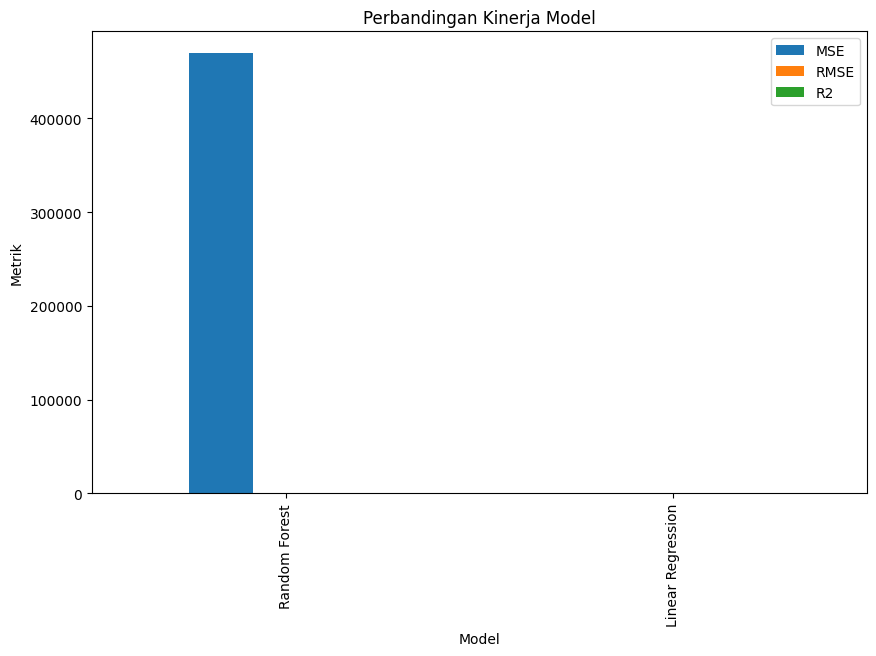

In [145]:
# Tampilkan hasil evaluasi model
print("\nHasil Evaluasi Model:\n", hasil_model)

# Plot metrik evaluasi sebagai diagram batang
fig, ax = plt.subplots(figsize=(10, 6))
hasil_model.set_index('Model')[['MSE', 'RMSE', 'R2']].plot(kind='bar', ax=ax)
plt.title("Perbandingan Kinerja Model")
plt.ylabel("Metrik")
plt.show()

In [149]:
# Prediksi dan pengujian dengan model Linear Regression
y_pred_lr_test = lr_model.predict(X_test)

# Menghitung metrik evaluasi untuk Linear Regression pada data uji
mse_lr_test = mean_squared_error(y_test, y_pred_lr_test)
rmse_lr_test = np.sqrt(mse_lr_test)
r2_lr_test = r2_score(y_test, y_pred_lr_test)

In [150]:
print("Model Linear Regression - Evaluasi Set Pengujian")
print(f"MSE: {mse_lr_test:.2f}")
print(f"RMSE: {rmse_lr_test:.2f}")
print(f"R²: {r2_lr_test:.2f}")
print("\n")

Model Linear Regression - Evaluasi Set Pengujian
MSE: 0.00
RMSE: 0.06
R²: 1.00




In [151]:
# Prediksi dan pengujian dengan model Random Forest Regressor
y_pred_rf_test = rf_model.predict(X_test)

# Menghitung metrik evaluasi untuk Random Forest pada data uji
mse_rf_test = mean_squared_error(y_test, y_pred_rf_test)
rmse_rf_test = np.sqrt(mse_rf_test)
r2_rf_test = r2_score(y_test, y_pred_rf_test)

In [152]:
print("Model Random Forest - Evaluasi Set Pengujian")
print(f"MSE: {mse_rf_test:.2f}")
print(f"RMSE: {rmse_rf_test:.2f}")
print(f"R²: {r2_rf_test:.2f}")

Model Random Forest - Evaluasi Set Pengujian
MSE: 469475.10
RMSE: 685.18
R²: 1.00


# Inferensi

In [154]:
# Membuat data prediksi sesuai dengan kolom fitur yang ada pada data pelatihan
data_prediksi = pd.DataFrame({
    'Year': [2024],  # Misalnya tahun saat prediksi
    'Annual Cost Increase (applied to initial and last phases)': [0.02],  # Angka kenaikan biaya tahunan
    'Initial Year After Diagnosis Cost': [10000],  # Misalnya biaya untuk tahun pertama setelah diagnosis
    'Continuing Phase Cost': [5000],  # Biaya untuk fase lanjutan
    'Last Year of Life Cost': [20000],  # Biaya pada tahun terakhir hidup
    'Cancer Site_Bladder': [0],
    'Cancer Site_Brain': [0],
    'Cancer Site_Breast': [0],
    'Cancer Site_Cervix': [1],  # Kanker serviks
    'Cancer Site_Colorectal': [0],
    'Cancer Site_Esophagus': [0],
    'Cancer Site_Head_Neck': [0],
    'Cancer Site_Kidney': [0],
    'Cancer Site_Leukemia': [0],
    'Cancer Site_Lung': [0],
    'Cancer Site_Lymphoma': [0],
    'Cancer Site_Melanoma': [0],
    'Cancer Site_Other': [0],
    'Cancer Site_Ovary': [0],
    'Cancer Site_Pancreas': [0],
    'Cancer Site_Prostate': [0],
    'Cancer Site_Stomach': [0],
    'Cancer Site_Uterus': [0],
    'Sex_Females': [1],  # Pasien perempuan
    'Sex_Males': [0],
    'Incidence and Survival Assumptions_Incidence, Survival at constant rate': [0],
    'Incidence and Survival Assumptions_Incidence, Survival follow recent trends': [0],
    'Incidence and Survival Assumptions_Survival follows recent trend, Incidence constant': [1],
})

# Menyesuaikan kolom prediksi untuk memiliki jumlah dan urutan kolom yang sama dengan data pelatihan
data_prediksi = data_prediksi.reindex(columns=X_train_df.columns, fill_value=0)

# Prediksi biaya pengobatan menggunakan model Linear Regression
prediksi_cost = lr_model.predict(data_prediksi)

# Menampilkan hasil prediksi biaya pengobatan
print(f'Prediksi biaya pengobatan untuk pasien umur 37 tahun dengan kanker serviks: {prediksi_cost[0]:.2f}')


Prediksi biaya pengobatan untuk pasien umur 37 tahun dengan kanker serviks: 372746037.03


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
